In [1]:
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
/var/folders/_1/x3m5fj893m70szcpz50r4zh00000gn/T/ipykernel_15825/1758919893.py in ?()
     13 
     14 # 2. Transformer les données en DataFrame Polars
     15 runs_data = []
     16 for _, run in runs.iterrows():
---> 17     model_name = run.tags.mlflow_runName
     18 
     19     # Extraire les métriques RMSE pour les 5 stats
     20     attack_rmse = run.metrics.get("attack_RMSE", None)

~/projects/PKMN.DB/.venv/lib/python3.12/site-packages/pandas/core/generic.py in ?(self, name)
   6295             and name not in self._accessors
   6296             and self._info_axis._can_hold_identifiers_and_holds_name(name)
   6297         ):
   6298             return self[name]
-> 6299         return object.__getattribute__(self, name)

AttributeError: 'Series' object has no attribute 'tags'

AttributeError: 'Series' object has no attribute 'tags'

Colonnes disponibles dans le DataFrame runs:
['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'metrics.sp_defense_RMSE', 'metrics.speed_R2', 'metrics.speed_RMSE', 'metrics.sp_attack_R2', 'metrics.attack_RMSE', 'metrics.average_RMSE', 'metrics.defense_RMSE', 'metrics.defense_R2', 'metrics.sp_defense_R2', 'metrics.sp_attack_RMSE', 'metrics.attack_R2', 'metrics.average_R2', 'tags.mlflow.user', 'tags.mlflow.source.type', 'tags.mlflow.runName', 'tags.mlflow.source.name', 'tags.mlflow.log-model.history']

Évaluation des modèles (triés par performance):
shape: (4, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Model      ┆ Attack_RMS ┆ Defense_RM ┆ Sp_Attack ┆ Sp_Defens ┆ Speed_RMS ┆ Average_R ┆ Run_ID    │
│ ---        ┆ E          ┆ SE         ┆ _RMSE     ┆ e_RMSE    ┆ E         ┆ MSE       ┆ ---       │
│ str        ┆ ---        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ str       

,Attack_RMSE,Defense_RMSE,Sp_Attack_RMSE,Sp_Defense_RMSE,Speed_RMSE,Average_RMSE
Model,,,,,,
Gradient Boosting Chain,24.383029,23.592595,14.562827,18.707272,13.554200,18.959984
Gradient Boosting,24.383029,22.285353,14.348739,17.859028,18.756094,19.526448
Random Forest,23.958951,23.649818,29.650365,17.028013,32.722734,25.401976
Decision Tree,26.823497,31.837478,41.141524,16.825576,45.939090,32.513433


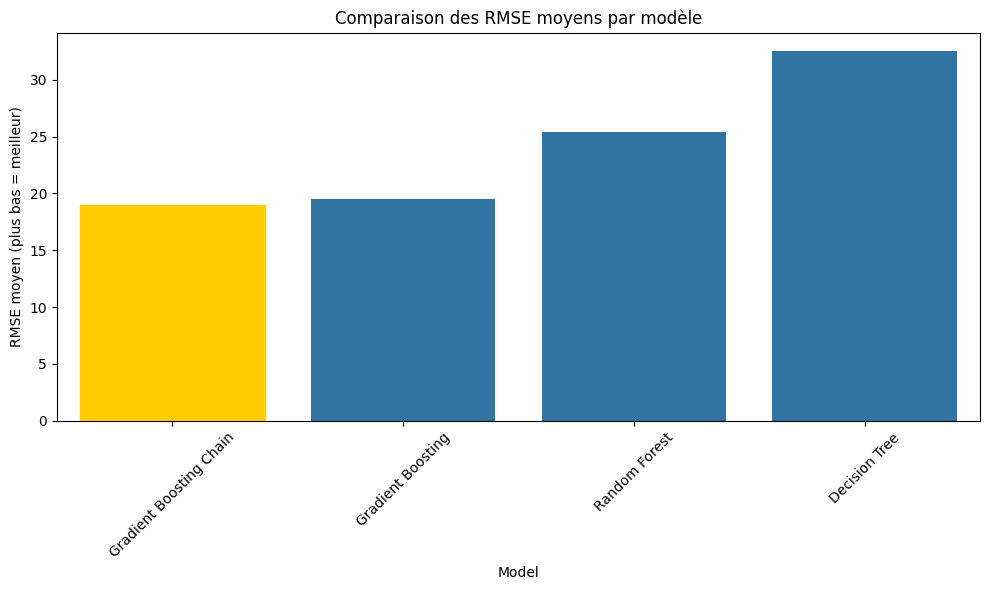

In [2]:
import mlflow
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Récupérer les données des runs depuis MLflow
experiment = mlflow.get_experiment_by_name("mega_evolution_prediction")
experiment_id = experiment.experiment_id

# Récupérer tous les runs
runs = mlflow.search_runs(experiment_ids=[experiment_id])

# Examiner la structure des données
print("Colonnes disponibles dans le DataFrame runs:")
print(runs.columns.tolist())

# 2. Transformer les données en DataFrame Polars
runs_data = []
for _, run in runs.iterrows():
    # Extraire le nom du modèle à partir de la colonne appropriée
    # Généralement 'tags.mlflow.runName' ou similaire
    model_name = None
    for col in runs.columns:
        if 'runName' in col:
            model_name = run[col]
            break
    
    if model_name is None:
        # Fallback: utiliser un identifiant unique
        model_name = f"Run {run.run_id}"
    
    # Extraire les métriques RMSE pour les 5 stats
    attack_rmse = None
    defense_rmse = None
    sp_attack_rmse = None
    sp_defense_rmse = None
    speed_rmse = None
    
    # Chercher les métriques dans les colonnes
    for col in runs.columns:
        if 'attack_RMSE' in col and 'sp_attack' not in col:
            attack_rmse = run[col]
        elif 'defense_RMSE' in col and 'sp_defense' not in col:
            defense_rmse = run[col]
        elif 'sp_attack_RMSE' in col:
            sp_attack_rmse = run[col]
        elif 'sp_defense_RMSE' in col:
            sp_defense_rmse = run[col]
        elif 'speed_RMSE' in col:
            speed_rmse = run[col]
        elif 'average_RMSE' in col:
            avg_rmse = run[col]
    
    # Vérifier si toutes les métriques sont disponibles
    if all(m is not None for m in [attack_rmse, defense_rmse, sp_attack_rmse, sp_defense_rmse, speed_rmse]):
        # Stocker les résultats
        runs_data.append({
            "Model": model_name,
            "Attack_RMSE": attack_rmse,
            "Defense_RMSE": defense_rmse,
            "Sp_Attack_RMSE": sp_attack_rmse,
            "Sp_Defense_RMSE": sp_defense_rmse,
            "Speed_RMSE": speed_rmse,
            "Average_RMSE": avg_rmse if 'avg_rmse' in locals() else (attack_rmse + defense_rmse + sp_attack_rmse + sp_defense_rmse + speed_rmse) / 5,
            "Run_ID": run.run_id if 'run_id' in run else 'unknown'
        })

# Créer un DataFrame Polars à partir des données
if runs_data:
    eval_df = pl.from_pandas(pd.DataFrame(runs_data))
    
    # 3. Trier par RMSE moyen (du meilleur au moins bon)
    eval_df = eval_df.sort("Average_RMSE")
    
    # 4. Afficher les résultats
    print("\nÉvaluation des modèles (triés par performance):")
    print(eval_df)
    
    # Trouver le meilleur modèle
    best_model = eval_df[0, "Model"]
    best_rmse = eval_df[0, "Average_RMSE"]
    print(f"\nMeilleur modèle: {best_model} avec RMSE moyen de {best_rmse:.2f}")
    
    # 5. Visualisation des résultats avec mise en évidence du gagnant
    pd_df = eval_df.to_pandas()
    
    # Tableau des RMSE par stat et par modèle
    rmse_stats = pd_df[["Model", "Attack_RMSE", "Defense_RMSE", "Sp_Attack_RMSE", "Sp_Defense_RMSE", "Speed_RMSE", "Average_RMSE"]]
    rmse_stats = rmse_stats.set_index("Model")
    
    # Style pour mettre en évidence le meilleur modèle
    def highlight_best(s):
        is_best = s.index == best_model
        return ['background-color: #FFFFCC' if v else '' for v in is_best]
    
    styled_df = rmse_stats.style.apply(highlight_best, axis=0)
    display(styled_df)
    
    # Graphique comparatif des RMSE moyens
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(data=pd_df, x="Model", y="Average_RMSE")
    
    # Colorer la barre du meilleur modèle
    for i, bar in enumerate(bars.patches):
        if pd_df.iloc[i]["Model"] == best_model:
            bar.set_color("#FFCC00")  # Jaune pour le gagnant
    
    plt.title("Comparaison des RMSE moyens par modèle")
    plt.ylabel("RMSE moyen (plus bas = meilleur)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée de run trouvée. Assurez-vous que les runs MLflow existent avec les métriques requises.")